# Machine Learning for Asset Managers

## Chapter 4 Optimal Clustering

### Snippet 4.1 Base Clustering

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

In [2]:
def clusterKMeansBase(corr0, maxNumClusters = 10, n_init = 10) :

    x = ((1-corr0.fillna(0))/2)**0.5
    silh = pd.Series()   # Observations matrix
    
    for init in range(n_init) :
        for i in range (2, maxNumClusters +1) :
            kmeans_ = KMeans(n_clusters = i, n_init=1)
            kmeans_ = kmeans_.fit(x)
            
            silh_ = silhouette_samples(x, kmeans_.labels_)
            stat = (silh_.mean() / silh_.std(), silh.mean()/silh.std())
            
            if np.isnan(stat[1]) or stat[0] > stat[1] :
                silh = silh_
                kmeans = kmeans_
    
    # Reordering
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx] # reorder rows
    corr1 = corr1.iloc[:, newIdx] # reorder columns
    
    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() \
             for i in np.unique(kmeans.labels_)}  # cluster members
    silh = pd.Series(silh, index = x.index)
    
    return corr1, clstrs, silh
    

### Snippet 4.2 Top-Level of Clustering

In [3]:
from sklearn.metrics import silhouette_samples

In [20]:
def makeNewOutputs(corr0, clstrs, clstrs2) :
    
    clstrsNew = {}
    
    # Allocate elements of cluster 1 and 2 to one dictionary (clstrsNew)
    for key_i in clstrs.keys() :
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[key_i])
        
    for key_j in clstrs2.keys() :
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[key_j])
        
    # need study
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    
    # Rearrange the correlation matrix
    corrNew = corr0.loc[newIdx, newIdx]
    
    # Correlation to distance
    x = ((1 - corr0.fillna(0))/ 2.0) ** 0.5
    
    kmeans_labels = np.zeros(len(x.columns))
    print(kmeans_labels)
    
    # Get index using clstrsNew cluster and x's value
    for idx in clstrsNew.keys() :
        idxs = [x.index.get_loc(k) for k in clstrsNew[idx]]
        
    silhNew = pd.Series(silhouette_samples(x, kmeans_labels), index = x.index)
    
    return corrNew, clstrsNew, silhNew


def clusterKMeansTop(corr0, maxNumClusters=None, n_init = 10) :
    
    # If there's no maxNumClusters value, set its value lenth(corr) - 1
    if maxNumClusters == None :
        maxNumClusters = corr0.shape[1] - 1 
        
    corr1, clstrs, silh = clusterKMeansBase(corr0, 
                                            maxNumClusters = min(maxNumClusters, corr0.shape[1] -1),
                                            n_init = n_init)
    
    clusterTstats = {i:np.mean(silh[clstrs[i]])/ np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    
    tStatMean = sum(clusterTstats.values()) / len(clusterTstats)
    
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    
    if len(redoClusters) <= 1 :
        return corr1, clstrs, silh
    
    else :
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        
        corrTmp = corr0.loc[keysRedo, keysRedo]
        tStatMean = np.mean([clusterTstats[i] for i in redoClusters])
        
        corr2, clstrs2, silh2 = clusterKMeansTop(corrTmp,
                                                maxNumClusters = min(maxNumClusters, corrTmp.shape[1] -1),
                                                n_init = n_init)
        
        # Make new outputs, if necessary
        
        corrNew, clstrsNew, silhNew = \
        makeNewOutputs(corr0,
                       {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},
                      clstrs2)
        
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]]) / np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        
        if newTstatMean <= tStatMean :
            return corr1, clstrs, silh
        
        else :
            return corrNew, clstrsNew, silhNew

### Snippet 4.3 Random Block Correlation Matrix Creation

In [5]:
import numpy as np
import pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state

In [6]:
def getCovSub(nObs, nCols, sigma, random_state = None) :
    
    # Sub correl matrix
    rng = check_random_state(random_state)
    
    if nCols == 1:
        return np.ones((1,1))
    
    ar0 = rng.normal(size=(nObs, 1))
    ar0 = np.repeat(ar0, nCols, axis =1 )
    ar0 += rng.normal(scale=sigma, size = ar0.shape)
    ar0 = np.cov(ar0, rowvar=False)
    
    return ar0


def getRndBlockCov(nCols, nBlocks, minBlockSize=1, sigma = 1.0, random_state=None):
    
    # Generate a block random correlation matrix
    rng = check_random_state(random_state)
    parts = rng.choice(range(1, nCols - (minBlockSize -1) * nBlocks), nBlocks-1, replace=False)
    parts.sort()
    parts = np.append(parts, nCols - (minBlockSize - 1) * nBlocks)
    parts = np.append(parts[0], np.diff(parts)) -1 + minBlockSize
    
    cov = None
    
    for nCols_ in parts :
        cov_ = getCovSub(int(max(nCols_ * (nCols_ + 1)/2.0, 100)),
                        nCols_,
                        sigma,
                        random_state = rng)
        
        if cov is None :
            cov = cov_.copy()
        else :
            cov = block_diag(cov, cov_)
            
    return cov
    


def randomBlockCorr(nCols, nBlocks, random_state = None, minBlockSize=1) :
        
        
    # Form block corr
    rng = check_random_state(random_state)
    
    cov0 = getRndBlockCov(nCols, nBlocks,
                         minBlockSize = minBlockSize,
                         sigma = 0.5,
                         random_state = rng)
    
    # Add Noise
    cov1 = getRndBlockCov(nCols, 1,
                         minBlockSize = minBlockSize,
                         sigma = 1.0,
                         random_state = rng)
        
    cov0 += cov1
    
    corr0 = cov2corr(cov0)
    corr0 = pd.DataFrame(corr0)
    
    return corr0

#### Define dependecies

In [7]:
def cov2corr(cov) :
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std,std)
    
    # Clipping to prevent numerical errors
    corr[corr <-1] = -1
    corr[corr > 1] = 1
    
    return corr

### Figure 4.3 Example of a random block correlation matrix, before shuffling.

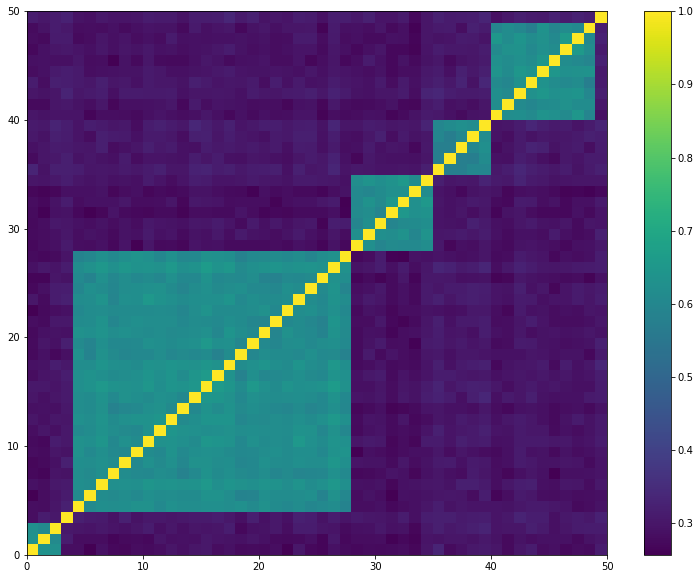

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = randomBlockCorr(nCols = 50, nBlocks = 7, random_state = 1)

plt.rcParams["figure.figsize"] = (13,10)
plt.pcolor(corr)
plt.colorbar()
plt.show()

### Figure 4.4 Boxplots of estimated K/actual K for bucketed K/N.

In [29]:
K_N_deciles = [(0.001,0.1), (0.1,0.2), (0.2,0.3), (0.3,0.4), (0.4,0.5)]
K_N_deciles_str = ["(0.001, 0.1]", "(0.1, 0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]"]

MIN_CLUSTER = 2
LOOP_SIZE = 1000
Ns = np.array([20, 40, 80, 160])

In [32]:
result_dict = {}

for i, interval in enumerate(K_N_deciles[1:]) :
    
    # Redefine Ns to fit each range
    Nr = Ns[np.where(Ns*interval[1] > MIN_CLUSTER )]
    
    
    #
    result_list = []
    
    for _ in range(LOOP_SIZE) :
        
        # Define Random N in given range Nr
        N = np.random.choice(Nr, 1)[0]
        
        # Define Random K in given range Kr
        Kr = np.arange(interval[0], interval[1], (interval[1] - interval[0])/LOOP_SIZE)
        Kr = (Kr * N ).astype(np.int32)
        K = max(np.random.choice(Kr, 1)[0], 2)
        
        # Create New Randdom block's corr
        corr = randomBlockCorr(nCols = N, nBlocks = K)
        
        # Clustering by KMeansTop
        corrNew, clstrsNew, silhNew = clusterKMeansTop(corr0 = corr)
        
        # Save data to list
        result_list.append(len(clstrsNew))
        
    
    result_dict[interval] = result_list
    

[ 20  40  80 160]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [18]:

Ns * 0.01

array([0.2, 0.4, 0.8, 1.6])